# Descriptive Analysis Pipeline

This notebook performs the following tasks:

1. **Data Cleaning & Validation**
   - Missing values, duplicates, numeric coercions, outlier detection, categorical checks.
2. **Descriptive Analysis**
   - On:
     - `dim_clients`
     - `fact_client_monthly`
     - `fact_transactions_daily`
3. **Reporting**
   - Build reporting tables:
     - `dim_client_report`
     - `fact_client_monthly_report`
     - `fact_transactions_daily_report`
4. **Save Results**
   - Export reporting outputs to **local storage (`reports/` folder)** in CSV format.


In [1]:
# ================== 1. Imports & Config ==================
import os
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import duckdb
import numpy as np

# DuckDB connection config
DB_PATH = "C:/Users/Reverside/Documents/Git/UbuntuBankSA/data/ubuntubank.db"

## 2. Helper Functions
Includes:
- **Duckdb fetcher** (fetch all rows, no sampling)
- **Data cleaning checks**
- **Local save helper**

In [2]:
# ================== 2. Helper Functions ==================
def get_duckdb_connection():
    """Get connection to DuckDB database"""
    return duckdb.connect(DB_PATH)

def fetch_table(conn, table_name):
    """Fetch all rows from a DuckDB table"""
    query = f"SELECT * FROM {table_name}"
    return conn.execute(query).fetchdf()

# ------------------ DATA PREP HELPERS ------------------
def check_missing(df, name):
    missing = df.isna().sum()
    missing = missing[missing > 0]
    if not missing.empty:
        print(f"{name}: Missing values\n{missing}")
    else:
        print(f"{name}: No missing values")

def check_duplicates(df, name, subset=None):
    before = df.shape[0]
    df = df.drop_duplicates(subset=subset, keep="first").reset_index(drop=True)
    dropped = before - df.shape[0]
    print(f"{name}: {dropped} duplicates removed" if dropped else f"{name}: No duplicates")
    return df

def ensure_numeric(df, col, name):
    if col in df.columns:
        before = df[col].isna().sum()
        df[col] = pd.to_numeric(df[col], errors="coerce")
        after = df[col].isna().sum()
        delta = after - before
        print(f"{name}.{col}: coerced to numeric; +{delta} NaNs" if delta > 0 else f"{name}.{col}: numeric conversion OK")
    return df

def detect_and_handle_outliers(df, col, name, method="iqr_adjust", multiplier=1.5):
    """
    Detect and handle outliers using a specified method
    
    Parameters:
    - method: "iqr_adjust" (adjusts outliers to fence values), "remove", or "ignore"
    - multiplier: controls how far the fences are from the quartiles (default 3.0 for more conservative approach)
    """
    if col not in df.columns or not pd.api.types.is_numeric_dtype(df[col]):
        return df, 0
    
    # Calculate IQR and fences
    q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - multiplier * iqr
    upper_fence = q3 + multiplier * iqr
    
    # Identify outliers
    outliers_mask = (df[col] < lower_fence) | (df[col] > upper_fence)
    n_outliers = outliers_mask.sum()
    
    if method == "iqr_adjust" and n_outliers > 0:
        # Adjust outliers to fence values instead of removing
        df.loc[df[col] < lower_fence, col] = lower_fence
        df.loc[df[col] > upper_fence, col] = upper_fence
        print(f"{name}.{col}: {n_outliers} outliers adjusted to fence values")
    elif method == "remove" and n_outliers > 0:
        # Remove outliers
        df = df[~outliers_mask]
        print(f"{name}.{col}: {n_outliers} outliers removed")
    else:
        print(f"{name}.{col}: {n_outliers} outliers detected")
    
    return df, n_outliers

def validate_categorical(df, col, allowed, name):
    if col in df.columns:
        invalid = set(df[col].dropna().unique()) - set(allowed)
        print(f"{name}.{col}: invalid categories {invalid}" if invalid else f"{name}.{col}: categories valid")
    return df

## 3. Connect to duckdb

In [3]:
conn = get_duckdb_connection()
print("Connected to DuckDB")

Connected to DuckDB


## 4. Data Cleaning & Descriptive Analysis

We analyze three tables:
1. `dim_clients`
2. `fact_client_monthly`
3. `fact_transactions_daily`


### 4.1 `dim_clients`


=== DATA PREP: dim_client ===
dim_client: No missing values
dim_client: No duplicates
dim_client.segment: invalid categories {'Enterprise'}
dim_client.kyc_status: invalid categories {'In Review', 'Rejected'}

=== dim_client (sample) ===


,client_sk,client_id,valid_from,valid_to,is_current,legal_name,registration_no,onboarding_date,years_in_business,employees_band,turnover_band,segment,kyc_status,relationship_manager_id,geography_sk,industry_sk
0,1,C000001,2023-01-03,2025-02-08,True,Client 1 (Pty) Ltd,REG0000001,05/10/2017,23,21-50,R20m-R100m,Small,Verified,RM037,46,7
1,2,C000002,2023-01-03,2025-02-08,True,Client 2 (Pty) Ltd,REG0000002,07/18/2018,25,101-250,R5m-R20m,Micro,Verified,RM004,42,1
2,3,C000003,2023-01-03,2025-02-08,True,Client 3 (Pty) Ltd,REG0000003,02/04/2018,1,1-20,R20m-R100m,Small,Verified,RM011,27,8
3,4,C000004,2023-01-03,2025-02-08,True,Client 4 (Pty) Ltd,REG0000004,12/31/2017,22,21-50,< R5m,Micro,Verified,RM064,43,8
4,5,C000005,2023-01-03,2025-02-08,True,Client 5 (Pty) Ltd,REG0000005,06/27/2019,21,51-100,R5m-R20m,Medium,Pending,RM099,47,3



Client segments distribution:
segment
Micro         11927
Small          9128
Medium         4448
Corporate      2988
Enterprise     1509
Name: count, dtype: int64

KYC status distribution:
kyc_status
Verified     22533
In Review     3094
Pending       2937
Rejected      1436
Name: count, dtype: int64


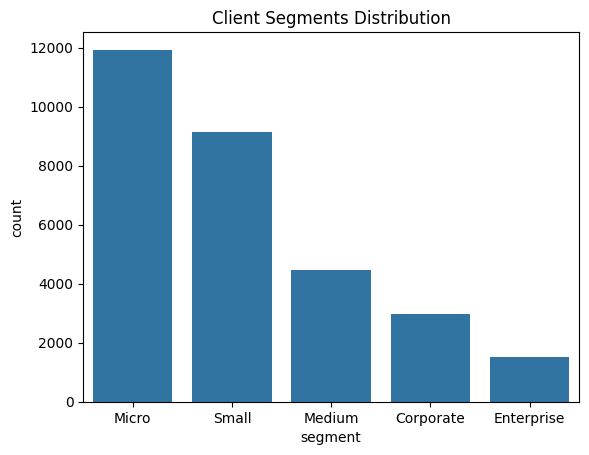

In [4]:
dim_client = fetch_table(conn, "dim_client")

print("\n=== DATA PREP: dim_client ===")
check_missing(dim_client, "dim_client")
dim_client = check_duplicates(dim_client, "dim_client", subset=["client_sk"])
validate_categorical(dim_client, "segment", ["Micro","Small","Medium","Corporate"], "dim_client")
validate_categorical(dim_client, "kyc_status", ["Verified","Pending","Review"], "dim_client")

print("\n=== dim_client (sample) ===")
display(dim_client.head())

# Distribution analysis
print("\nClient segments distribution:")
print(dim_client["segment"].value_counts())
print("\nKYC status distribution:")
print(dim_client["kyc_status"].value_counts())

sns.countplot(data=dim_client, x="segment", order=dim_client["segment"].value_counts().index)
plt.title("Client Segments Distribution")
plt.show()

In [5]:
dim_client.describe()

,client_sk,valid_from,valid_to,years_in_business,geography_sk,industry_sk
count,30000.000000,30000,30000,30000.000000,30000.000000,30000.000000
mean,15000.500000,2023-01-03 00:00:00,2025-02-08 00:00:00,15.638100,25.560300,5.496867
min,1.000000,2023-01-03 00:00:00,2025-02-08 00:00:00,1.000000,1.000000,1.000000
25%,7500.750000,2023-01-03 00:00:00,2025-02-08 00:00:00,8.000000,13.000000,3.000000
50%,15000.500000,2023-01-03 00:00:00,2025-02-08 00:00:00,16.000000,26.000000,5.000000
75%,22500.250000,2023-01-03 00:00:00,2025-02-08 00:00:00,23.000000,38.000000,8.000000
max,30000.000000,2023-01-03 00:00:00,2025-02-08 00:00:00,30.000000,50.000000,10.000000
std,8660.398374,NaN,NaN,8.679127,14.460187,2.872966


### 4.2 `fact_client_monthly`


=== DATA PREP: fact_client_monthly ===
fact_client_monthly: Missing values
last_campaign_sk    49469
dtype: int64
fact_client_monthly: 2452 duplicates removed
fact_client_monthly.avg_balance: numeric conversion OK
fact_client_monthly.avg_balance: 41772 outliers adjusted to fence values
fact_client_monthly.inflow_txn_cnt: numeric conversion OK
fact_client_monthly.inflow_txn_cnt: 7398 outliers adjusted to fence values
fact_client_monthly.outflow_txn_cnt: numeric conversion OK
fact_client_monthly.outflow_txn_cnt: 7365 outliers adjusted to fence values

=== fact_client_monthly (sample) ===


,client_sk,month_sk,avg_balance,inflow_txn_cnt,outflow_txn_cnt,inflow_amount,outflow_amount,intl_txn_flag,digital_logins_cnt,self_service_usage_flag,avg_ticket_size,days_active,has_merchant,has_forex,has_payroll,has_savings,email_open_rate,email_ctr,last_campaign_sk
0,1,202317,33309.64,18,19,35473.19,32120.70,False,17,True,1646.50,25,False,False,True,True,66.39,4.89,2.0
1,1,202305,152121.19,7,6,46335.85,56629.42,True,11,True,7881.61,2,True,False,True,False,33.14,6.95,1.0
2,1,202304,58565.46,7,6,75250.53,60650.99,False,20,False,11078.18,20,False,False,True,False,32.12,15.21,1.0
3,1,202303,85378.89,19,18,159212.39,200063.11,False,19,True,10040.62,19,False,False,True,False,29.82,6.22,1.0
4,1,202321,11478.40,15,14,200748.41,185620.51,False,15,True,11339.61,14,False,False,True,True,39.20,6.27,4.0



Balance statistics:
count    490442.000000
mean      50867.184105
std       48488.873217
min         290.770000
25%       13894.717500
50%       31920.020000
75%       72400.572500
max      160159.355000
Name: avg_balance, dtype: float64

Inflow/Outflow Txn Count statistics:
       inflow_txn_cnt  outflow_txn_cnt
count   490442.000000    490442.000000
mean        11.453501        11.449876
std          5.736505         5.732160
min          1.000000         1.000000
25%          7.000000         7.000000
50%         11.000000        11.000000
75%         15.000000        15.000000
max         27.000000        27.000000


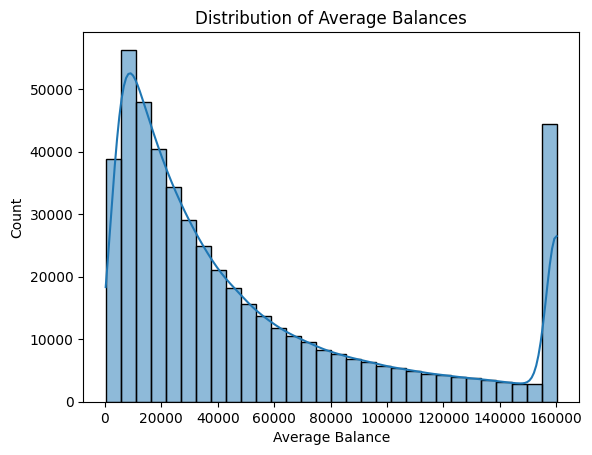

In [6]:
fact_client_monthly = fetch_table(conn, "fact_client_monthly")

print("\n=== DATA PREP: fact_client_monthly ===")
check_missing(fact_client_monthly, "fact_client_monthly")
fact_client_monthly = check_duplicates(fact_client_monthly, "fact_client_monthly", subset=["client_sk","month_sk"])

# Handle numeric columns with conservative outlier adjustment
for col in ["avg_balance","inflow_txn_cnt","outflow_txn_cnt"]:
    fact_client_monthly = ensure_numeric(fact_client_monthly, col, "fact_client_monthly")
    fact_client_monthly, n_outliers = detect_and_handle_outliers(
        fact_client_monthly, col, "fact_client_monthly", 
        method="iqr_adjust", multiplier=1.5
    )

print("\n=== fact_client_monthly (sample) ===")
display(fact_client_monthly.head())

# Basic stats
print("\nBalance statistics:")
print(fact_client_monthly["avg_balance"].describe())
print("\nInflow/Outflow Txn Count statistics:")
print(fact_client_monthly[["inflow_txn_cnt","outflow_txn_cnt"]].describe())

sns.histplot(fact_client_monthly["avg_balance"], bins=30, kde=True)
plt.title("Distribution of Average Balances")
plt.xlabel("Average Balance")
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(20000))
plt.show()

### 4.3 `fact_transactions_daily`

In [7]:
fact_txn_daily = fetch_table(conn, "fact_transactions_daily")

print("\n=== DATA PREP: fact_transactions_daily ===")
check_missing(fact_txn_daily, "fact_transactions_daily")
fact_txn_daily = check_duplicates(fact_txn_daily, "fact_transactions_daily", subset=["client_sk","date_sk"])

# Handle numeric columns with conservative outlier adjustment
for col in ["debit_amt","credit_amt"]:
    fact_txn_daily = ensure_numeric(fact_txn_daily, col, "fact_transactions_daily")
    fact_txn_daily, n_outliers = detect_and_handle_outliers(
        fact_txn_daily, col, "fact_transactions_daily", 
        method="iqr_adjust", multiplier=3.0
    )

print("\n=== fact_transactions_daily (sample) ===")
display(fact_txn_daily.head())

# Daily transaction volumes
daily_vol = (
    fact_txn_daily.groupby("date_sk")[["debit_amt","credit_amt"]]
    .sum()
    .reset_index()
)
print("\nDaily transaction volume (first few days):")
print(daily_vol.head())
print(fact_txn_daily.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


=== DATA PREP: fact_transactions_daily ===
fact_transactions_daily: No missing values
fact_transactions_daily: 83871 duplicates removed
fact_transactions_daily.debit_amt: numeric conversion OK
fact_transactions_daily.debit_amt: 341967 outliers adjusted to fence values
fact_transactions_daily.credit_amt: numeric conversion OK
fact_transactions_daily.credit_amt: 336038 outliers adjusted to fence values

=== fact_transactions_daily (sample) ===


,client_sk,date_sk,debit_cnt,debit_amt,credit_cnt,credit_amt,cross_border_cnt,cross_border_amt
0,1.0,20230213,1,1886.50,1,25931.13,0,0.0
1,1.0,20240824,2,1703.73,2,13957.33,0,0.0
2,1.0,20240527,1,400.29,2,56754.68,0,0.0
3,1.0,20230918,0,0.00,2,35398.48,0,0.0
4,1.0,20241107,1,3038.24,2,33924.25,0,0.0



Daily transaction volume (first few days):
    date_sk     debit_amt    credit_amt
0  20230101  5.858340e+08  7.257580e+08
1  20230102  5.844516e+08  7.104066e+08
2  20230103  5.821849e+08  7.169450e+08
3  20230104  5.814055e+08  7.078836e+08
4  20230105  5.808687e+08  7.135506e+08
(16774250, 8)


In [10]:
# Assuming 'daily_vol' is the dataframe you want to format
# The original code up to this point:
# daily_vol = (
#     fact_txn_daily.groupby("date_sk")[["debit_amt","credit_amt"]]
#     .sum()
#     .reset_index()
# )

# Create a copy to avoid a SettingWithCopyWarning
daily_vol_formatted = daily_vol.copy()

# Format the numeric columns with a comma as a thousands separator and 2 decimal places
daily_vol_formatted['debit_amt'] = daily_vol_formatted['debit_amt'].map('{:,.2f}'.format)
daily_vol_formatted['credit_amt'] = daily_vol_formatted['credit_amt'].map('{:,.2f}'.format)

print("\nDaily transaction volume (first few days):")
print(daily_vol_formatted.head())
print(fact_txn_daily.shape)


Daily transaction volume (first few days):
    date_sk       debit_amt      credit_amt
0  20230101  585,833,956.22  725,757,997.02
1  20230102  584,451,590.04  710,406,647.00
2  20230103  582,184,918.93  716,944,963.81
3  20230104  581,405,468.96  707,883,601.99
4  20230105  580,868,668.39  713,550,581.03
(16774250, 8)


## 6. Save

In [8]:
# ================== 7. Save Cleaned Data Back to DuckDB ==================

def save_to_duckdb(conn, df, table_name):
    """
    Save a pandas DataFrame back into DuckDB as a table
    (overwrites the table if it already exists).
    """
    conn.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df")

print("\n=== SAVING CLEANED TABLES TO DUCKDB ===")
save_to_duckdb(conn, dim_client, "dim_clients_cleaned")
save_to_duckdb(conn, fact_client_monthly, "fact_client_monthly_cleaned")
save_to_duckdb(conn, fact_txn_daily, "fact_transactions_daily_cleaned")

print("All cleaned tables saved to DuckDB")


=== SAVING CLEANED TABLES TO DUCKDB ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

All cleaned tables saved to DuckDB


In [9]:
conn.close()

# Pipeline Complete

We have:
- Pulled **all rows** from Supabase using pagination.
- Cleaned and validated the datasets.
- Performed descriptive statistics.
- Built reporting outputs.
- Saved results into **local storage (`reports/` folder)**.